# Predict ice content from resistivity spectra with Neural Networks (sklearn)

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

import utils.ml
import utils.sip
import utils.etl
from utils.analysis import *
from utils.plot import *

# Get paths for tables and plots
from utils.etl import path_plots, path_tables

from scipy import io
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Output everything
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### Handle for reimporting `utils`

In [2]:
import importlib
importlib.reload(utils.sip)

<module 'utils.sip' from '/Users/h_boinowitz/bachelorarbeit/code/utils/sip.py'>

### Set constants

In [3]:
SAMPLE_NUM = 600000
SAMPLE_SIZE_FITTING = 50000

## Choosing random Zorin-Ageev Parameters
### Definition of the Zorin-Ageev model

The first model to be discussed is the so called Zorin-Ageev model given by
\begin{equation}
    \sigma(\omega)^k = (1-\alpha)\,\tilde\sigma_m^k(\omega) + \alpha \tilde\sigma_i^k(\omega),     
\end{equation}
where
\begin{equation}
    \tilde\sigma_m = \frac{1}{\rho_m} + i\omega\epsilon_0\epsilon_m
\end{equation}
and
\begin{equation}
    \tilde\sigma_i = \frac{1}{\rho_{\mathrm{DC},\,i}} + i\omega\epsilon_0 \left[\epsilon_{\mathrm{HF},\,i} + \frac{\epsilon_{\mathrm{DC},\,i} - \epsilon_{\mathrm{HF},\,i}}{1+ \left(i\omega\tau_i\right)^c}\right].
\end{equation}
Now, 600000 random combinations of parameters are chosen.


In [4]:
random_zorin_ageev_params = utils.sip.get_random_parameters(SAMPLE_NUM)
random_zorin_ageev_params.to_pickle("../data/random_ageev_params.pkl")

## Statistical description of the Data Set

### Histograms

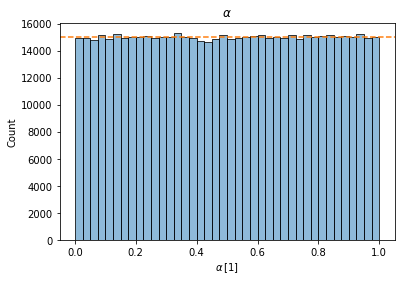

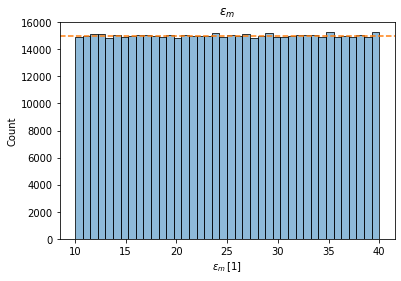

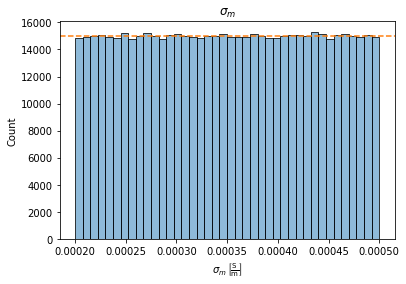

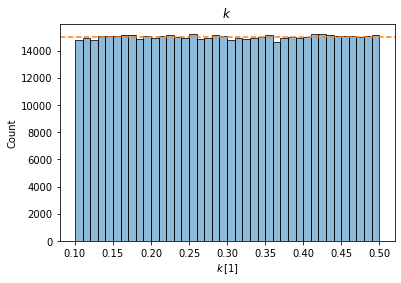

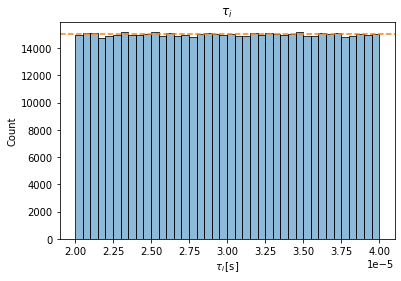

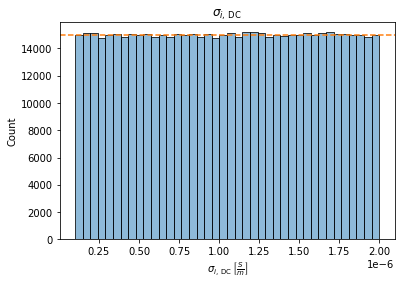

In [5]:
plot_parameter_histograms(random_zorin_ageev_params)

### Table of statistical Properties

In [6]:
frame_export = utils.etl.get_export_ready_frame(random_zorin_ageev_params)
frame_export.iloc[1:].to_latex(f'{path_tables}/_distribution_greek.tex', 
                                            formatters=formatters,
                                            escape = False,
                                            caption="Statistical description of randomly chosen"\
                                            " Zorin-Ageev parameters' distribution",
                                            label = "tab:synthetic_data_distr")
random_zorin_ageev_params.describe().T

count       mean           std           min           25%  \
alpha       600000.0   0.500498  2.888236e-01  1.549600e-06  2.500622e-01   
epsilon_m   600000.0  25.009383  8.660984e+00  1.000011e+01  1.750707e+01   
sigma_m     600000.0   0.000350  8.658946e-05  2.000001e-04  2.750739e-04   
k           600000.0   0.300229  1.155356e-01  1.000012e-01  2.000995e-01   
tau_i       600000.0   0.000030  5.770468e-06  2.000003e-05  2.500465e-05   
sigma_i_DC  600000.0   0.000001  5.485535e-07  1.000055e-07  5.749530e-07   

                  50%        75%        max  
alpha        0.500820   0.751102   0.999997  
epsilon_m   25.012230  32.513468  39.999989  
sigma_m      0.000350   0.000425   0.000500  
k            0.299988   0.400657   0.499999  
tau_i        0.000030   0.000035   0.000040  
sigma_i_DC   0.000001   0.000002   0.000002

## Classical Approach on Synthetic Data

### Add Spectral Information to Random Zorin-Ageev Parameters

In [7]:
zorin_ageev_with_spectra = utils.sip.add_zorin_ageev_spectrum_to_frame(random_zorin_ageev_params)
zorin_ageev_with_spectra

alpha  epsilon_m   sigma_m         k     tau_i    sigma_i_DC  \
0       0.830390  26.523937  0.000234  0.173891  0.000029  1.856632e-06   
1       0.338248  31.244435  0.000293  0.405969  0.000034  1.135319e-06   
2       0.911508  18.727142  0.000263  0.258516  0.000035  1.340932e-06   
3       0.880932  25.324828  0.000469  0.397570  0.000035  2.023960e-07   
4       0.965837  36.788409  0.000370  0.106815  0.000040  1.546495e-06   
...          ...        ...       ...       ...       ...           ...   
599995  0.124483  11.356156  0.000271  0.276981  0.000037  1.674588e-06   
599996  0.682994  15.429501  0.000320  0.473701  0.000023  1.708941e-07   
599997  0.686833  30.495021  0.000341  0.231849  0.000033  1.133337e-06   
599998  0.816431  13.085321  0.000206  0.255689  0.000038  4.126095e-07   
599999  0.253119  26.048251  0.000459  0.183089  0.000020  7.762346e-07   

                                     spectrum_zorin_ageev  
0       [5.933674241235007e-06, 5.9343075649691565e-06...  
1       [0.00012064903671702714, 0.0001206507373842632...  
2       [3.261608592968184e-06, 3.2622998861120526e-06...  
3       [4.701662229256662e-06, 4.711093266510609e-06,...  
4       [1.990557913169495e-06, 1.9910083059160624e-06...  
...                                                   ...  
599995  [0.00018950952323530917, 0.0001895105320162028...  
599996  [3.220585828575784e-05, 3.2221448659561565e-05...  
599997  [1.65846428484847e-05, 1.6586906711759107e-05,...  
599998  [3.4361279644934477e-06, 3.4403706171173523e-0...  
599999  [0.00016110463687131891, 0.0001611157958250555...  

[600000 rows x 7 columns]

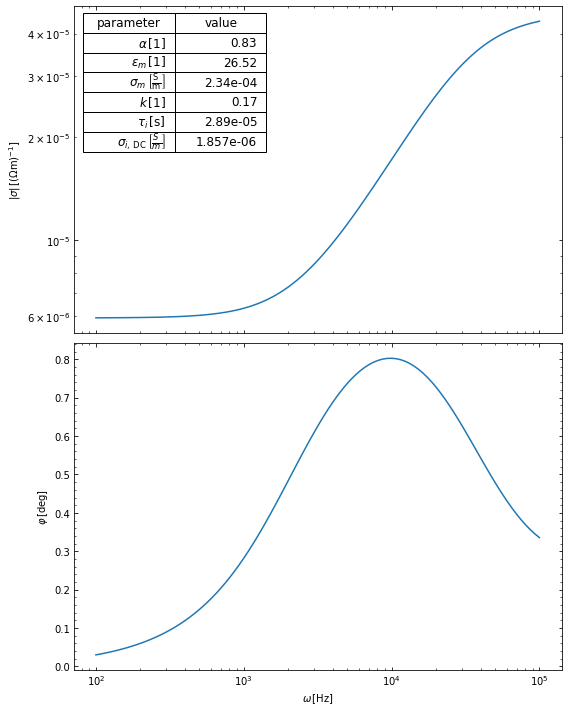

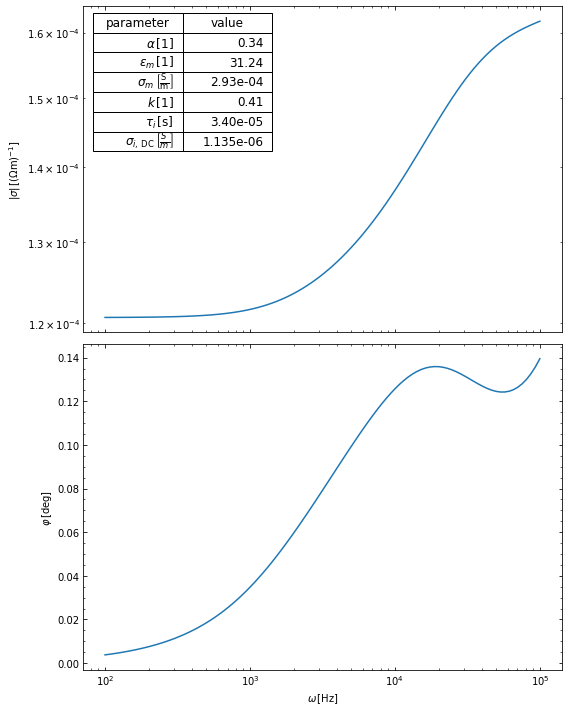

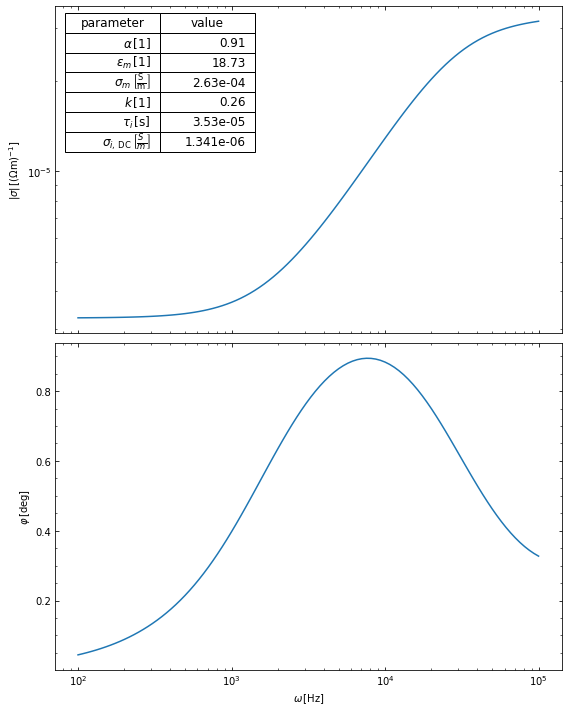

In [8]:
plot_example_spectra(zorin_ageev_with_spectra, save=True)

### Definition of the CCM

Here the Cole-Cole model given by
\begin{equation}
    \epsilon_r = \epsilon_\mathrm{HF} + \frac{\epsilon_\mathrm{DC}- \epsilon_\mathrm{HF}}{1+ (i\omega\tau)^c} + \frac{1}{i\omega\epsilon_0\rho_\mathrm{DC}}
\end{equation}
is used.

With $\sigma = i\omega\epsilon_0\epsilon_r$ this relative permittivity is transformed into a **specific conductivity**

### Fitting a CCM for every Zorin-Ageev Spectrum

In [9]:
# Comment this out, if fitting data already stored 
# zorin_ageev_with_fitted_ccm = utils.sip.generate_frame_with_fitted_spectrum(zorin_ageev_with_spectra, SAMPLE_SIZE_FITTING, True)

# # Calculate Dropout
# rows_before_fit = zorin_ageev_with_fitted_ccm.shape[0]
# zorin_ageev_with_fitted_ccm.dropna(inplace=True)
# rows_after_fit = zorin_ageev_with_fitted_ccm.shape[0]

# print(f'Dropout: {1 - rows_after_fit/rows_before_fit:.2%}')

# # Remove spectral columns
# non_spectral_columns = [col for col in zorin_ageev_with_fitted_ccm.columns if not "spectrum" in col]
# zorin_ageev_with_fitted_ccm_params = zorin_ageev_with_fitted_ccm.copy()[non_spectral_columns]
# zorin_ageev_with_fitted_ccm_params.to_pickle("../data/zorin_ageev_and_ccm_params.pkl")
# zorin_ageev_with_fitted_ccm

In [10]:
zorin_ageev_with_fitted_ccm_params = pd.read_pickle("../data/zorin_ageev_and_ccm_params.pkl")
zorin_ageev_with_fitted_ccm_params.describe()
zorin_ageev_with_fitted_ccm = utils.sip.add_spectra_to_pickled_frame(zorin_ageev_with_fitted_ccm_params)

alpha     epsilon_m       sigma_m             k         tau_i  \
count  45710.000000  45710.000000  45710.000000  45710.000000  45710.000000   
mean       0.501607     25.010101      0.000349      0.303928      0.000030   
std        0.298563      8.663375      0.000087      0.115616      0.000006   
min        0.000030     10.000714      0.000200      0.100003      0.000020   
25%        0.234035     17.497324      0.000274      0.204781      0.000025   
50%        0.497722     25.044582      0.000349      0.304670      0.000030   
75%        0.772623     32.523738      0.000425      0.405482      0.000035   
max        0.999978     39.999872      0.000500      0.499997      0.000040   

         sigma_i_DC    epsilon_HF    epsilon_DC           tau             c  \
count  4.571000e+04  45710.000000  45710.000000  45710.000000  45710.000000   
mean   1.062767e-06     -9.027297    461.123024      0.007851      0.747066   
std    5.475650e-07    391.564410    572.903554      0.603915      0.128386   
min    1.000156e-07 -61357.106850    -74.034431     -0.001856     -3.803363   
25%    5.921216e-07    -12.287010     90.741245      0.000090      0.703129   
50%    1.067151e-06     -4.954831    304.978401      0.000142      0.766408   
75%    1.538478e-06     -0.516851    643.936992      0.000236      0.815221   
max    1.999940e-06   8028.134991  23919.314825     72.957777      3.826907   

             rho_DC  
count  4.571000e+04  
mean   4.673610e+05  
std    4.778406e+06  
min    2.011715e+03  
25%    6.078613e+03  
50%    1.774831e+04  
75%    4.472146e+05  
max    3.742979e+08

### Examples

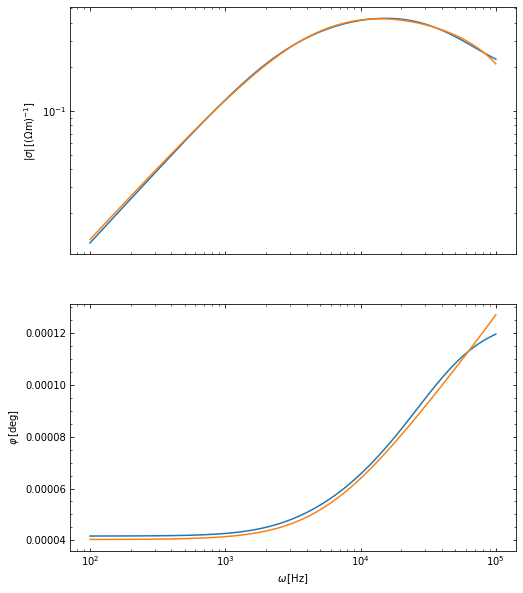

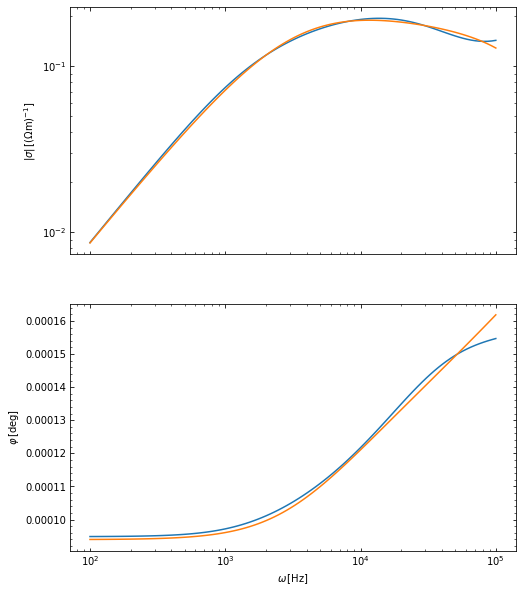

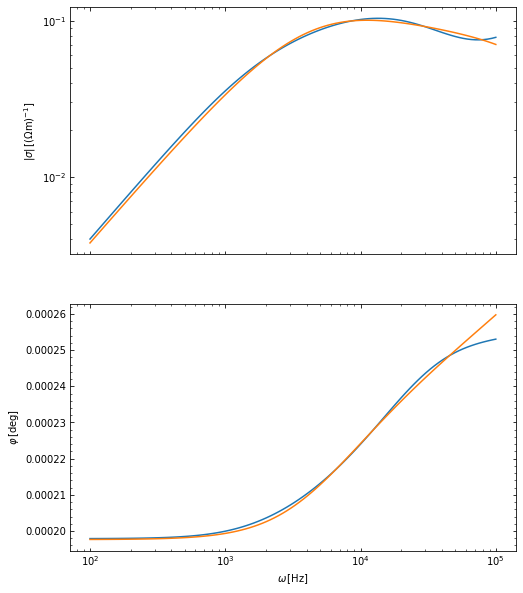

In [11]:
plot_comparing_spectra(zorin_ageev_with_fitted_ccm)

### Analyse Spectral Difference and Similarities

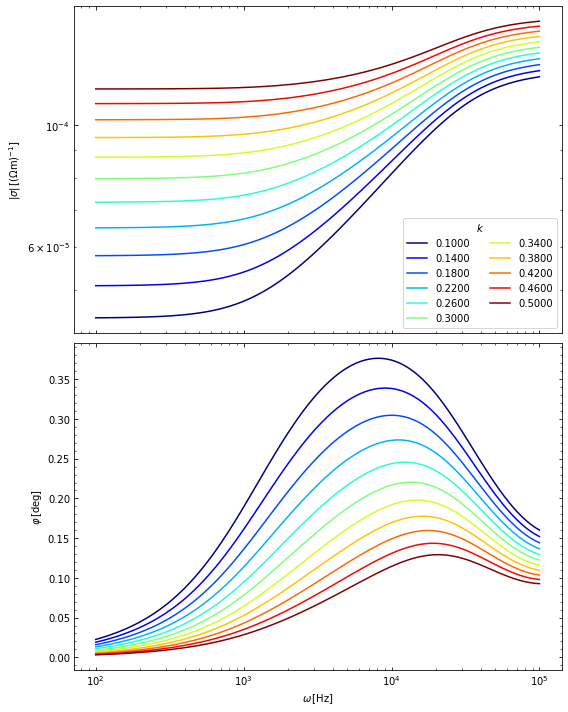

In [12]:
plot_spectra_for_different_values_of_k()


In [13]:
zorin_ageev_with_rmse = add_rmse_to_fitted_data(zorin_ageev_with_fitted_ccm)


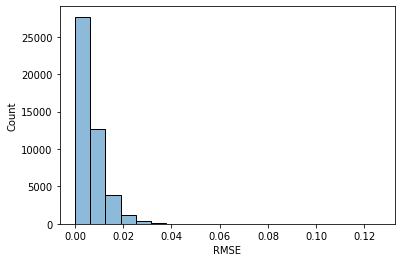

In [14]:
hist_rmse = sb.histplot(zorin_ageev_with_rmse['RMSE'], bins=20, alpha=.50)
plt.savefig(f"{path_plots}/analysis/dist_rmse.png", dpi=1000)

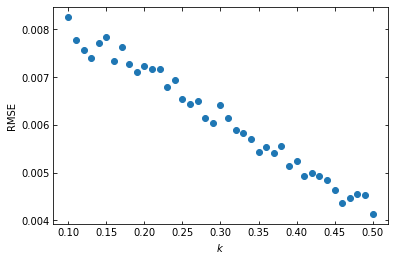

correlation coefficient between k and RMSE : 
    -0.9899
correlation coefficient between k and RMSE (with rounded values): 
    -0.9900


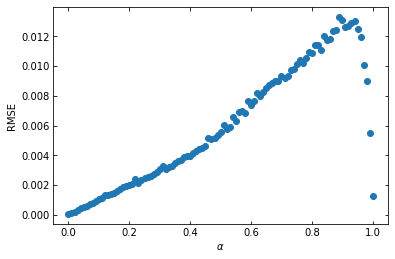

correlation coefficient between alpha and RMSE : 
    0.9256
correlation coefficient between alpha and RMSE (with rounded values): 
    0.9254


In [15]:
create_rmse_correlation_plots(zorin_ageev_with_rmse, 'k')
create_rmse_correlation_plots(zorin_ageev_with_rmse, 'alpha', greek=True)

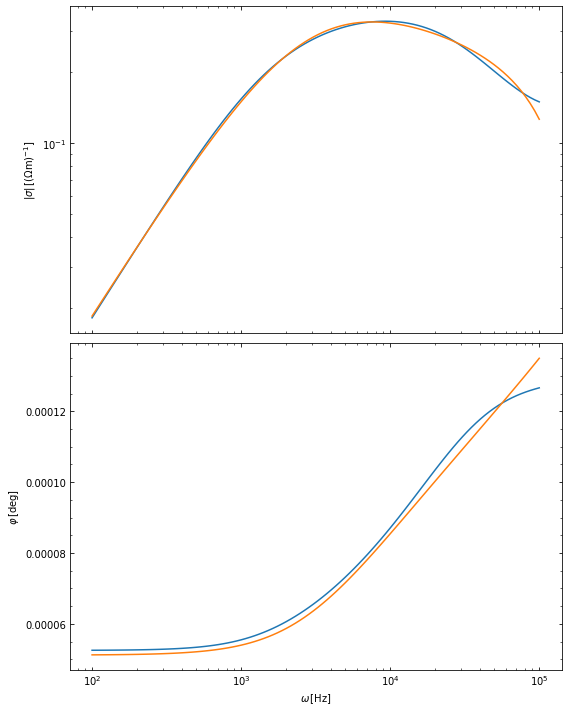

In [16]:
compare_plots(0.15)

## Designing Spectral Features 

### Explorative Data Analysis
To investigate, how different ice content influence the spectrum 11 spectra just differing in the value of the ice content $\alpha$ are plotted.

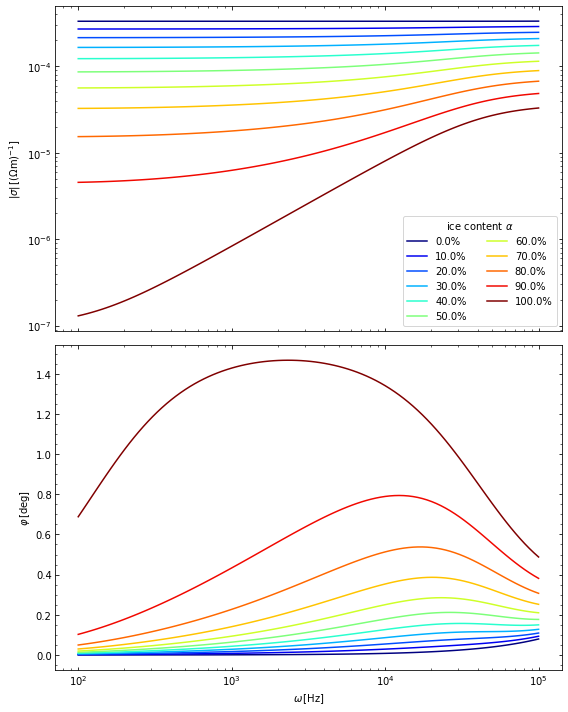

In [17]:
plot_spectra_for_different_ice_contents()

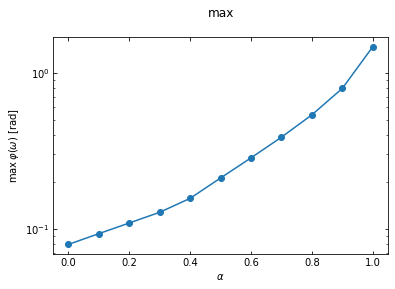

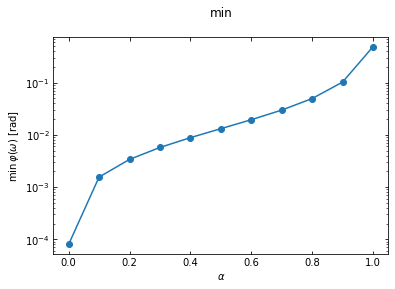

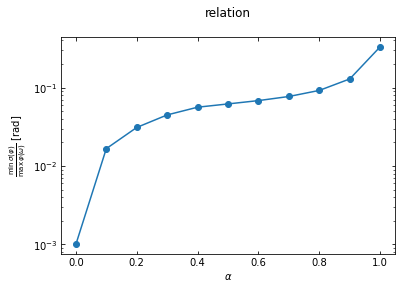

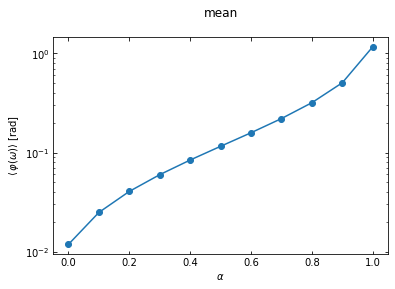

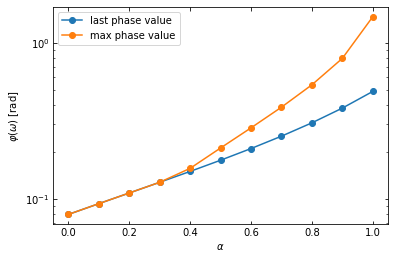

In [18]:
plot_feature_values_over_alpha()

In [19]:
zorin_ageev_with_spectral_features = generate_frame_with_features(zorin_ageev_with_spectra)
zorin_ageev_with_spectral_features

50000 rows finished.
100000 rows finished.
150000 rows finished.
200000 rows finished.
250000 rows finished.
300000 rows finished.
350000 rows finished.
400000 rows finished.
450000 rows finished.
500000 rows finished.
550000 rows finished.
600000 rows finished.


alpha  epsilon_m   sigma_m         k     tau_i    sigma_i_DC  \
0       0.830390  26.523937  0.000234  0.173891  0.000029  1.856632e-06   
1       0.338248  31.244435  0.000293  0.405969  0.000034  1.135319e-06   
2       0.911508  18.727142  0.000263  0.258516  0.000035  1.340932e-06   
3       0.880932  25.324828  0.000469  0.397570  0.000035  2.023960e-07   
4       0.965837  36.788409  0.000370  0.106815  0.000040  1.546495e-06   
...          ...        ...       ...       ...       ...           ...   
599995  0.124483  11.356156  0.000271  0.276981  0.000037  1.674588e-06   
599996  0.682994  15.429501  0.000320  0.473701  0.000023  1.708941e-07   
599997  0.686833  30.495021  0.000341  0.231849  0.000033  1.133337e-06   
599998  0.816431  13.085321  0.000206  0.255689  0.000038  4.126095e-07   
599999  0.253119  26.048251  0.000459  0.183089  0.000020  7.762346e-07   

                                     spectrum_zorin_ageev       min       max  \
0       [5.933674241235007e-06, 5.9343075649691565e-06... -3.503065 -0.219791   
1       [0.00012064903671702714, 0.0001206507373842632... -5.578991 -1.969486   
2       [3.261608592968184e-06, 3.2622998861120526e-06... -3.113239 -0.111977   
3       [4.701662229256662e-06, 4.711093266510609e-06,... -2.301871 -0.307475   
4       [1.990557913169495e-06, 1.9910083059160624e-06... -2.995470  0.008866   
...                                                   ...       ...       ...   
599995  [0.00018950952323530917, 0.0001895105320162028... -6.384958 -2.828868   
599996  [3.220585828575784e-05, 3.2221448659561565e-05... -3.620730 -0.954683   
599997  [1.65846428484847e-05, 1.6586906711759107e-05,... -3.619329 -0.600061   
599998  [3.4361279644934477e-06, 3.4403706171173523e-0... -2.365013 -0.217238   
599999  [0.00016110463687131891, 0.0001611157958250555... -4.592751 -1.678679   

            mean  relation  
0      -0.836632 -3.283274  
1      -2.592928 -3.609504  
2      -0.700277 -3.001263  
3      -0.741784 -1.994396  
4      -0.598027 -3.004335  
...          ...       ...  
599995 -3.413553 -3.556090  
599996 -1.511976 -2.666046  
599997 -1.166605 -3.019267  
599998 -0.666864 -2.147775  
599999 -2.170981 -2.914072  

[600000 rows x 11 columns]

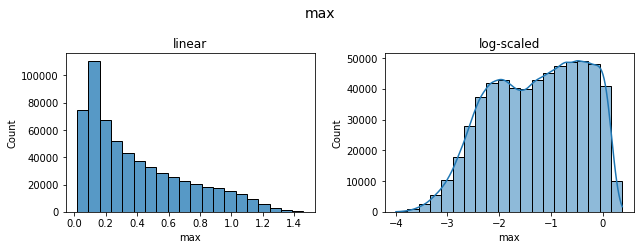

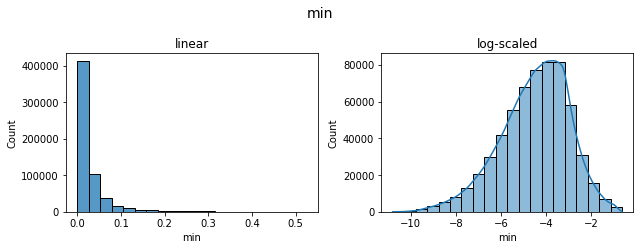

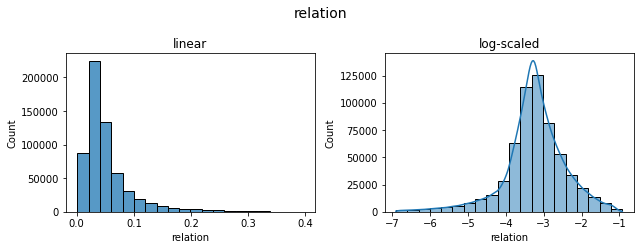

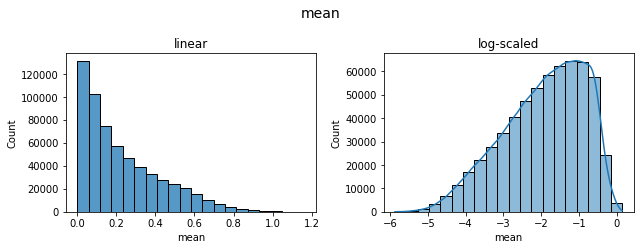

In [20]:
feature_hist_plot(zorin_ageev_with_spectral_features)

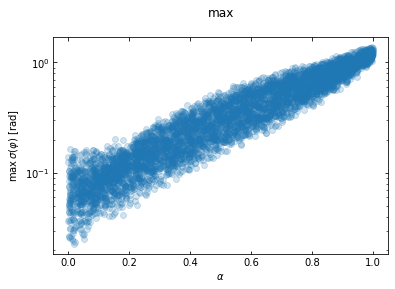

-0.6329270717276829


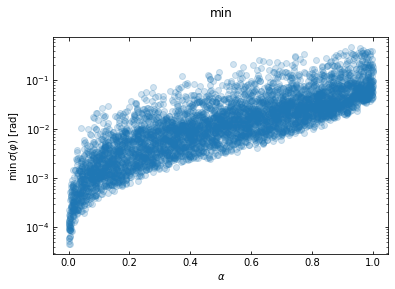

-0.517287940256517


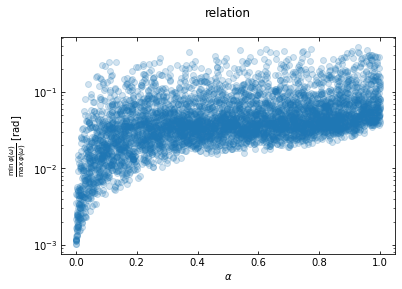

-0.20783579432593255


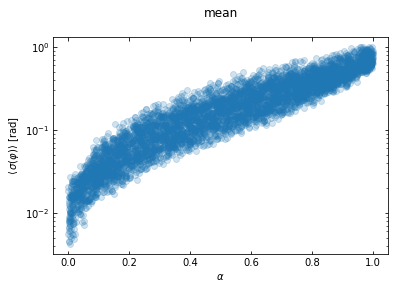

-0.602883843552783


In [21]:
sample_frame = zorin_ageev_with_spectral_features.sample(5000)
feature_scatter_plot(sample_frame)

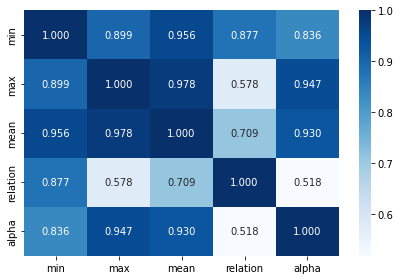

In [22]:
corr_frame = zorin_ageev_with_spectral_features[['min', 'max', 'mean', 'relation', 'alpha']]
corr_plot = sb.heatmap(corr_frame.corr(), annot=True, cmap='Blues',fmt=".3f")

plt.tight_layout()
plt.savefig(f'{path_plots}/analysis/correlation_matrix.png', dpi=800)
plt.show()

## Load CCM parameters for measurement in Russia and Generate Spectra for $\sigma$

In [23]:
mat = io.loadmat('../data/ccm_data_mudler_et_al.mat')

# Unpack nested data structure
con_list = [[element for element in upperElement] for upperElement in mat['CCeps'][0][0]]
zipped_data = list(zip(*con_list[0:5]))

column_names = ['rho', 'epsilon_DC', 'epsilon_HF', 'tau', 'c']
measured_data = pd.DataFrame(zipped_data, columns = column_names)
measured_data = measured_data.apply(pd.Series.explode).astype('float')

# Change the order of columns
measured_data = measured_data[['epsilon_HF', 'epsilon_DC', 'tau', 'c', 'rho']]
measured_data = measured_data.reset_index(drop=True)

measurements = measured_data.copy()
measurements = utils.sip.add_ccm_to_frame(measurements)

## Load ice contents for measurement in Russia

In [24]:
ice_content_matrix = io.loadmat('../data/ice_content_mudler_et_al.mat')
ice_content_arr = ice_content_matrix['ice'].transpose().reshape(-1)

ice_content = pd.DataFrame(ice_content_arr, columns=['alpha'])
ice_content.describe()

alpha
count  780.000000
mean     0.078669
std      0.091872
min      0.000000
25%      0.000000
50%      0.062451
75%      0.099434
max      0.757097

## Merge measured data and fitted ice content 

In [25]:
measured_frame = measurements.join(ice_content)

# Show DataFrame
measured_frame

epsilon_HF  epsilon_DC       tau       c     rho  \
0        12.190      395.90  0.000051  0.7517  2367.0   
1        12.080      198.00  0.000072  1.0000  2830.0   
2        12.870      210.50  0.000076  1.0000  2477.0   
3        13.390      324.10  0.000060  1.0000  2976.0   
4        13.280      521.80  0.000037  0.9611  3308.0   
..          ...         ...       ...     ...     ...   
775      10.140      103.90  0.000049  0.9863  2823.0   
776      10.110      102.30  0.000049  0.9874  2677.0   
777      10.060      100.20  0.000050  0.9876  2436.0   
778       9.913       96.56  0.000051  0.9889  2205.0   
779       9.329       89.63  0.000053  1.0000  3135.0   

                                          spectrum_ccm     alpha  
0    [0.00042248168142166405, 0.0004224824555061690...  0.000000  
1    [0.00035335812716361787, 0.000353358312357171,...  0.038611  
2    [0.0004037155379183082, 0.00040371574270473633...  0.049449  
3    [0.00033602328147873763, 0.0003360235474506393...  0.030306  
4    [0.0003022998980072579, 0.0003023002563948648,...  0.125796  
..                                                 ...       ...  
775  [0.00035423353479520055, 0.0003542336016086578...  0.167195  
776  [0.00037355292647763395, 0.0003735529922776201...  0.152891  
777  [0.00041050946750577274, 0.0004105095324119073...  0.132381  
778  [0.0004535151633662586, 0.0004535152265046759,...  0.126327  
779  [0.00031897965367023605, 0.0003189797116725775...  0.120594  

[780 rows x 7 columns]

## Copy plots from preprint

### Matrix plots for all Cole-Cole parameters

epsilon_HF  epsilon_DC       tau       c     rho  \
0        12.190      395.90  0.000051  0.7517  2367.0   
1        12.080      198.00  0.000072  1.0000  2830.0   
2        12.870      210.50  0.000076  1.0000  2477.0   
3        13.390      324.10  0.000060  1.0000  2976.0   
4        13.280      521.80  0.000037  0.9611  3308.0   
..          ...         ...       ...     ...     ...   
775      10.140      103.90  0.000049  0.9863  2823.0   
776      10.110      102.30  0.000049  0.9874  2677.0   
777      10.060      100.20  0.000050  0.9876  2436.0   
778       9.913       96.56  0.000051  0.9889  2205.0   
779       9.329       89.63  0.000053  1.0000  3135.0   

                                          spectrum_ccm     alpha  
0    [0.00042248168142166405, 0.0004224824555061690...  0.000000  
1    [0.00035335812716361787, 0.000353358312357171,...  0.038611  
2    [0.0004037155379183082, 0.00040371574270473633...  0.049449  
3    [0.00033602328147873763, 0.0003360235474506393...  0.030306  
4    [0.0003022998980072579, 0.0003023002563948648,...  0.125796  
..                                                 ...       ...  
775  [0.00035423353479520055, 0.0003542336016086578...  0.167195  
776  [0.00037355292647763395, 0.0003735529922776201...  0.152891  
777  [0.00041050946750577274, 0.0004105095324119073...  0.132381  
778  [0.0004535151633662586, 0.0004535152265046759,...  0.126327  
779  [0.00031897965367023605, 0.0003189797116725775...  0.120594  

[780 rows x 7 columns]

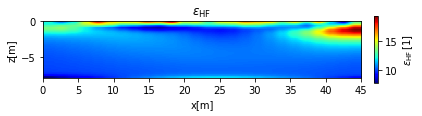

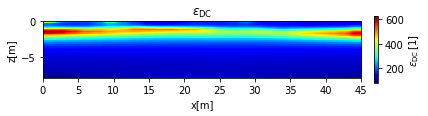

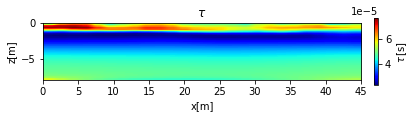

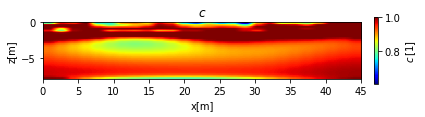

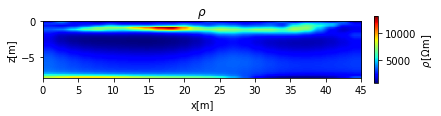

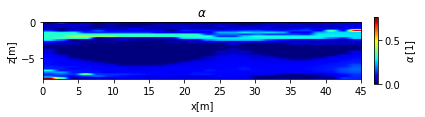

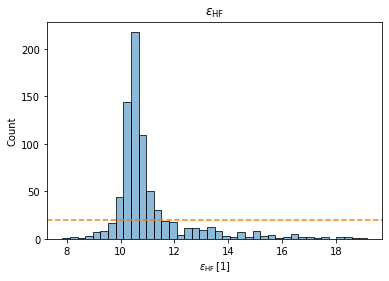

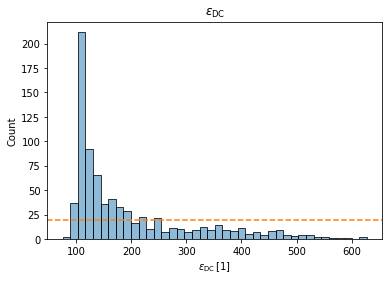

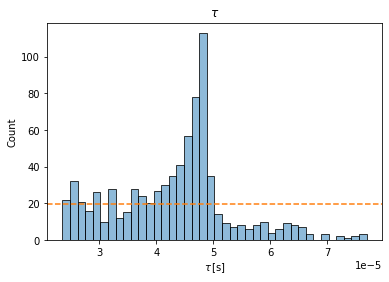

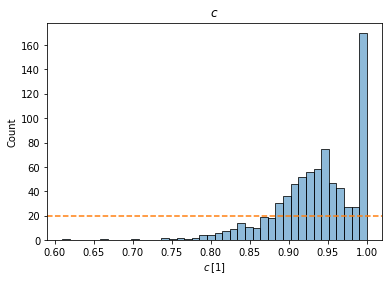

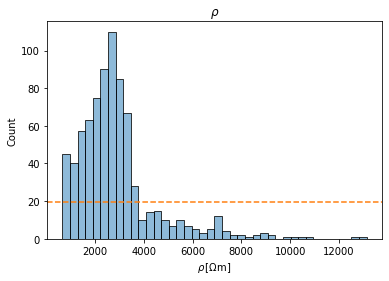

In [26]:
measured_frame
plot_spatial_distribution_ccm(measured_frame)
plot_parameter_histograms_ccm(measured_frame)

In [27]:
frame_export = utils.etl.get_export_ready_frame(measured_frame)

frame_export.iloc[1:, :-1].to_latex(f'{path_tables}/_distribution_ccm_greek.tex', 
                                            formatters=formatters,
                                            escape = False,
                                            caption= "Description of the CCM parameters' distribution in the measured field data",
                                            label = "tab:field_data_distr")
measured_frame.describe().T

count         mean          std         min          25%  \
epsilon_HF  780.0    11.074122     1.526803    7.841000    10.340000   
epsilon_DC  780.0   191.462756   112.572712   75.290000   111.400000   
tau         780.0     0.000043     0.000010    0.000023     0.000036   
c           780.0     0.935205     0.055483    0.609800     0.904975   
rho         780.0  2864.822692  1665.483400  660.700000  1873.250000   
alpha       780.0     0.078669     0.091872    0.000000     0.000000   

                    50%          75%           max  
epsilon_HF    10.580000    11.082500     19.150000  
epsilon_DC   141.100000   226.325000    627.700000  
tau            0.000045     0.000048      0.000077  
c              0.941350     0.981500      1.000000  
rho         2621.500000  3248.000000  13140.000000  
alpha          0.062451     0.099434      0.757097

In [28]:
field_data_with_spectral_features = generate_frame_with_features(measurements, spectral_type='ccm')

In [29]:
field_data_with_zorin_ageev = utils.sip.generate_frame_with_fitted_spectrum(measurements, get_params=True)

Finished `generate_frame_with_fitted_spectrum` in 90.58606 s.


In [30]:
field_data_with_zorin_ageev

epsilon_HF  epsilon_DC       tau       c     rho  \
0         10.15       282.7  0.000027  1.0000  2058.0   
1         11.01       212.3  0.000057  1.0000  7049.0   
2         13.53       190.5  0.000076  1.0000  2914.0   
3         10.57       134.4  0.000042  0.8986  2879.0   
4         11.49       424.7  0.000025  1.0000  1268.0   
..          ...         ...       ...     ...     ...   
775       10.71       328.2  0.000026  1.0000  1488.0   
776       10.84       241.9  0.000030  0.8959   854.5   
777       15.62       313.3  0.000046  0.7643  1640.0   
778       10.13       116.5  0.000046  0.9406  3320.0   
779       12.09       321.8  0.000027  1.0000  1984.0   

                                          spectrum_ccm  \
0    [0.00048590935963893297, 0.0004859094660350673...   
1    [0.00014186523401860744, 0.0001418654047075970...   
2    [0.00034317213586613734, 0.0003431723210665818...   
3    [0.00034734363708526737, 0.0003473437518021458...   
4    [0.0007886445377686879, 0.0007886446882202112,...   
..                                                 ...   
775  [0.0006720438050082447, 0.0006720439239525639,...   
776  [0.0011702761497079232, 0.0011702763102560425,...   
777  [0.0006097601179839963, 0.0006097606428037258,...   
778  [0.00030120542686636097, 0.0003012055149924670...   
779  [0.00050403307952376, 0.0005040332025418803, 0...   

                                  spectrum_zorin_ageev     alpha  epsilon_m  \
0    [0.00016877190536654344, 0.0001687719434449839...  0.912299   7.000000   
1    [0.00014186524034762055, 0.0001418654110365776...  0.044060  12.398375   
2    [0.00034317180362324295, 0.0003431719888226066...  0.003186  13.575412   
3    [0.00035373668196871647, 0.0003537367604756273...  0.114538  17.258431   
4    [0.00017344848346899724, 0.0001734485181365338...  0.913949   7.000000   
..                                                 ...       ...        ...   
775  [0.0002661594836424166, 0.00026615953484724155...  0.817152   7.000000   
776  [0.0008730259949171933, 0.0008730260603640126,...  0.185767  22.000000   
777  [0.00023961844264651187, 0.0002396185548110214...  0.220617  22.000000   
778  [0.0003012484838139762, 0.00030124855220148164...  0.044912  12.497360   
779  [0.00015660425124561957, 0.0001566042904735516...  0.917666   7.000000   

      sigma_m         k     tau_i  sigma_i_DC  
0    0.002000  0.930190  0.000026    0.000020  
1    0.000197 -1.000006  0.000029    0.000020  
2    0.000371 -1.000069  0.000022    0.000014  
3    0.000460  0.327962  0.000020    0.000010  
4    0.002000  0.952388  0.000025    0.000020  
..        ...       ...       ...         ...  
775  0.002000  0.786524  0.000024    0.000020  
776  0.001300  0.417724  0.000020    0.000020  
777  0.000346  0.644484  0.000020    0.000002  
778  0.000353 -0.060132  0.000020    0.000014  
779  0.002000  0.922194  0.000026    0.000020  

[780 rows x 13 columns]

### Ice content

Maximal ice content: 99.60%
Minimal ice content: 0.19%


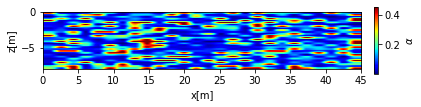

In [31]:
# Reshape column into two-dimensional array

alpha_nn = np.transpose(np.array(field_data_with_zorin_ageev['alpha']).reshape(26,30))

print(f"Maximal ice content: {np.max(alpha_nn):.2%}")
print(f"Minimal ice content: {np.min(alpha_nn):.2%}")
alpha_nn[alpha_nn > .45] = .45

setup_two_dimensional_profile(alpha_nn, r'$\alpha$')

plt.savefig(f'{path_plots}/field_data/classic_fit_paper.png', dpi=1000)
plt.show()

In [32]:
field_data_with_rmse = add_rmse_to_fitted_data(field_data_with_zorin_ageev)

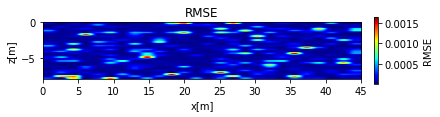

In [33]:
matrix = np.array(field_data_with_rmse['RMSE'])
matrix = np.transpose(matrix.reshape(26, 30))
setup_two_dimensional_profile(matrix, 'RMSE', 'RMSE')
plt.savefig(f"{path_plots}/field_data/spatial_distribution_rmse.png", bbox_inches='tight', dpi=1000)
plt.show()

## Training Neural Networks on Synthetic Data

### Setup

In [34]:
x_measured = measurements['spectrum_ccm'].apply(lambda arr: arr[100:]).tolist()
y_measured = np.log(measured_frame['alpha'].replace(0, 1e-6))

In [35]:
param_grid_neural = {
    'batch_size' : range(200, 600, 100),
    'alpha' : np.logspace(-6, -2, 3),
    'learning_rate_init' : np.logspace(-4, -2, 3)
}

param_grid_k_neigh = {
    'n_neighbors' : range(5, 23, 2),
    'weights' : ['uniform', 'distance'],
    'p' : [1, 2, 4]
}

param_grid_nested = lambda param_grid: {k: [list(v)] for k, v in param_grid.items()}
param_grid_nested_pd = lambda param_grid: pd.DataFrame.from_dict(param_grid_nested(param_grid), orient='index', columns=['Parameter Values'])

param_grid_neural_pd = param_grid_nested_pd(param_grid_neural)
param_grid_k_neigh_pd = param_grid_nested_pd(param_grid_k_neigh)

param_grid_neural_pd.to_latex(f'{path_tables}/params_hyper_tuning_neural_networks.tex', 
                        caption=r"Parameters for the Hyperparameter-Tuning of all three approaches using Neural Networks. In this Hyperparameter-Tuning the learning rate, the batch size and the parameter $\alpha$ that corresponds to the model's regularization are varried. Every parameter is varied independently, using a Grid Search Algorithm.",
                        label = f"tab:params_hyper_tuning_neural_networks")

param_grid_k_neigh_pd.to_latex(f'{path_tables}/params_hyper_tuning_k_neigh.tex', 
                        caption=r"Parameters for the Hyperparameter-Tuning for the approach using a $k$-nearest Neighbor Regressor. In this Hyperparameter-Tuning the number $n$ of neighbors, the strategy how the neighbors should be weighted based on their distance to a given point and the $p$-metrics to measure the distance between two points are varried. Every parameter is varied independently, using a Grid Search Algorithm.",
                        label = f"tab:params_hyper_tuning_k_neigh"
)



### Neural Network Learning directly on the Zorin-Ageev Spectrum

Finished `fit_model` in 14548.59066 s.
Free parameters: 7855


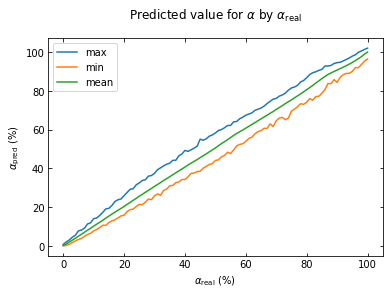

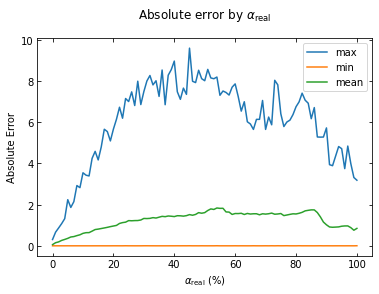

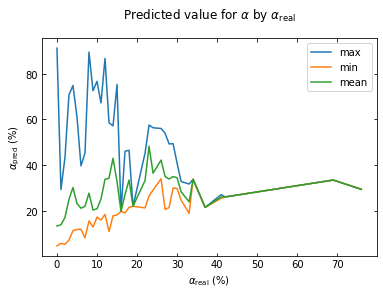

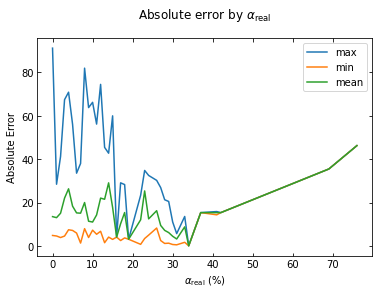

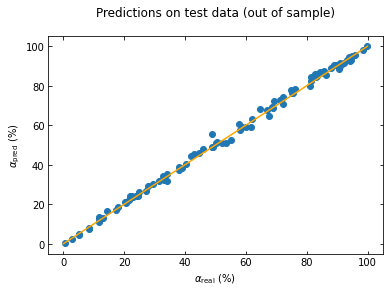

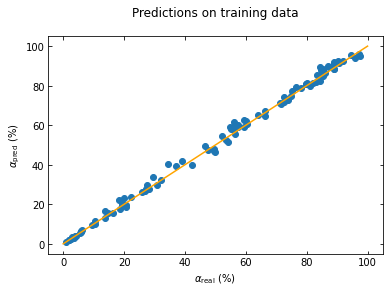

Maximal ice content: 91.12%
Minimal ice content: 4.83%


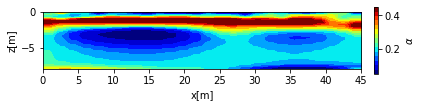

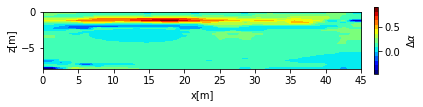

Finished `eval_model` in 26.43548 s.


score       RMSE
train       0.995993   1.676610
test        0.995632   1.682433
field data -0.511275  19.434506

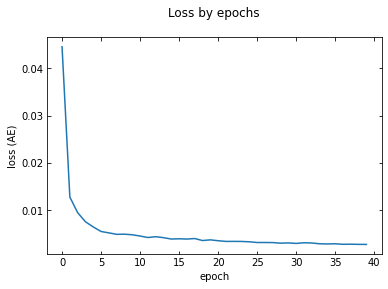

In [36]:
x = zorin_ageev_with_spectra['spectrum_zorin_ageev'].apply(lambda arr: arr[100:]).tolist()
y = np.log(zorin_ageev_with_spectra['alpha'])

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.6, test_size=0.4)

regressor_zorin_ageev = MLPRegressor(max_iter=1000, solver='adam', activation='relu', n_iter_no_change=10,
                         hidden_layer_sizes=(20, 40, 50, 40, 20, 10, 5), batch_size=400)

fitted_regressor_zorin_ageev = utils.ml.fit_model('zorin_ageev', regressor_zorin_ageev, x_train, y_train, param_grid_neural)

print(f"Free parameters: {utils.ml.get_num_of_free_parameters(fitted_regressor_zorin_ageev)}")
utils.ml.eval_model('zorin_ageev', fitted_regressor_zorin_ageev, x_train, y_train, x_test, y_test, 
                   x_measured, y_measured)
utils.ml.plot_learning_history(fitted_regressor_zorin_ageev, 'zorin_ageev')
utils.ml.export_model(fitted_regressor_zorin_ageev, '../models/zorin_ageev.pickle')

## Neural Network Learning directly on CCM Spectrum

Finished `fit_model` in 1590.17917 s.
Free parameters: 7855


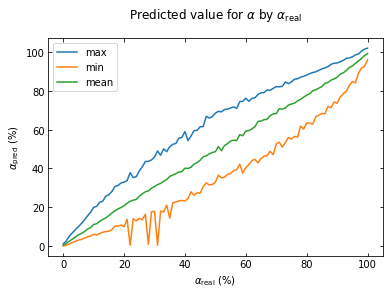

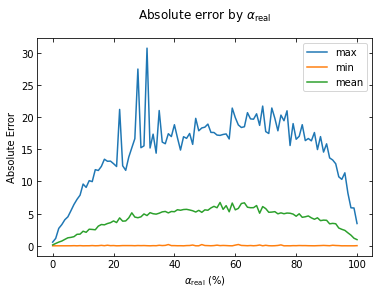

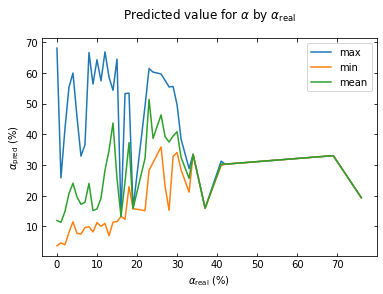

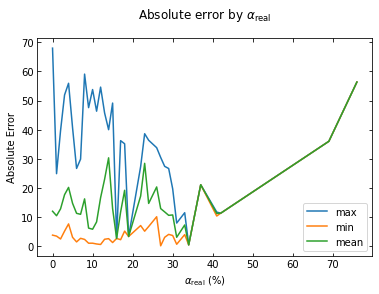

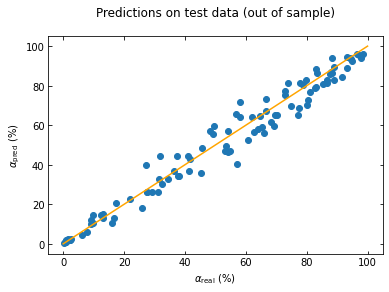

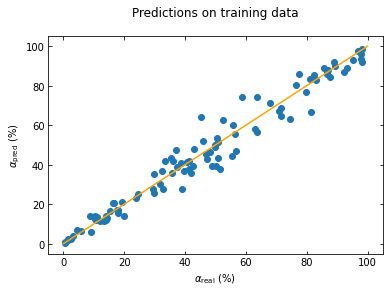

Maximal ice content: 68.02%
Minimal ice content: 3.69%


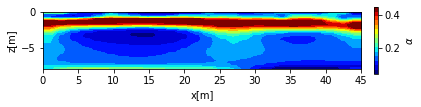

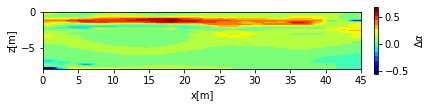

Finished `eval_model` in 21.99234 s.


score       RMSE
train       0.971973   5.532143
test        0.968615   5.568924
field data -0.474455  16.962484

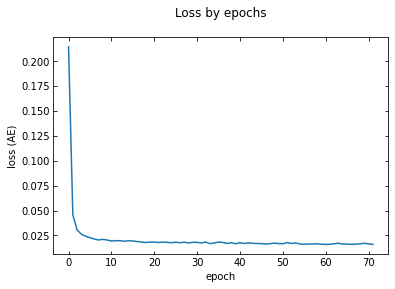

In [37]:
x = zorin_ageev_with_fitted_ccm['spectrum_ccm'].apply(lambda arr: arr[100:]).tolist()
y = np.log(zorin_ageev_with_fitted_ccm['alpha'])

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.6, test_size=0.4)

regressor_ccm = MLPRegressor(max_iter=3000, solver='adam', activation='relu', n_iter_no_change=10,
                         hidden_layer_sizes=(20, 40, 50, 40, 20, 10, 5), batch_size=400)

fitted_regressor_ccm = utils.ml.fit_model('ccm', regressor_ccm, x_train, y_train, param_grid_neural)

print(f"Free parameters: {utils.ml.get_num_of_free_parameters(fitted_regressor_ccm)}")
utils.ml.eval_model('ccm', fitted_regressor_ccm, x_train, y_train, x_test, y_test,
                  x_measured, y_measured)
utils.ml.plot_learning_history(fitted_regressor_ccm, 'ccm')
utils.ml.export_model(fitted_regressor_ccm, '../models/ccm.pickle')

## Neural Network Learning on Spectral Features

Finished `fit_model` in 13456.87025 s.
Free parameters: 5935


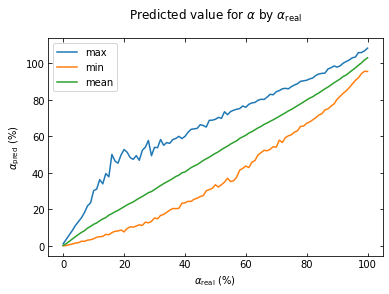

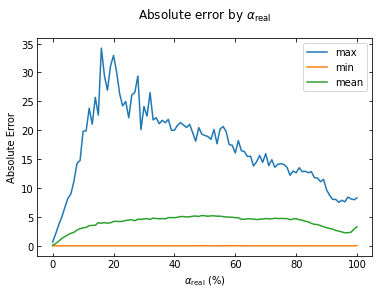

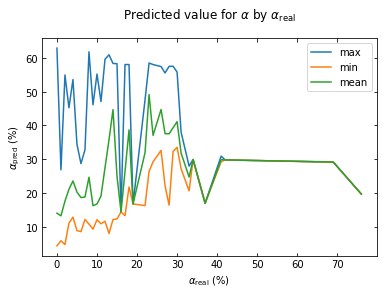

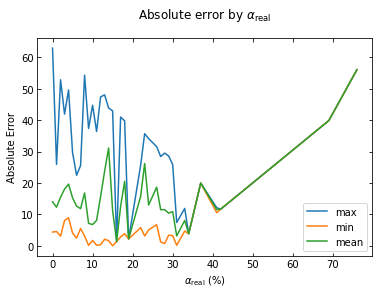

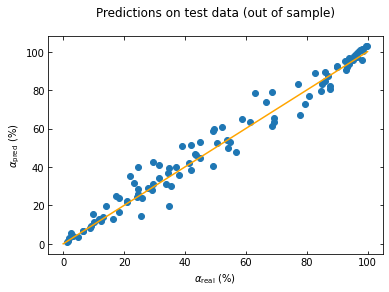

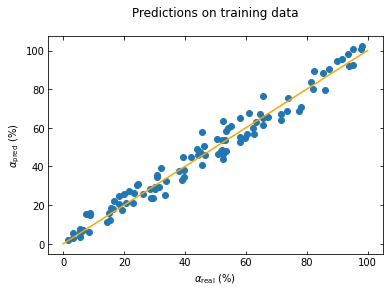

Maximal ice content: 62.84%
Minimal ice content: 4.41%


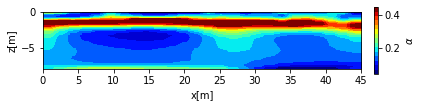

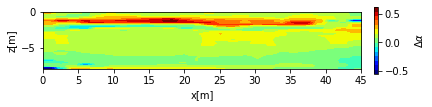

Finished `eval_model` in 23.53675 s.


score       RMSE
train       0.961908   5.260152
test        0.961781   5.257085
field data -0.522918  17.183434

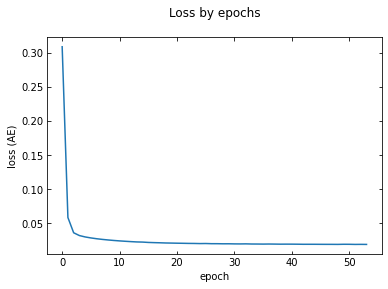

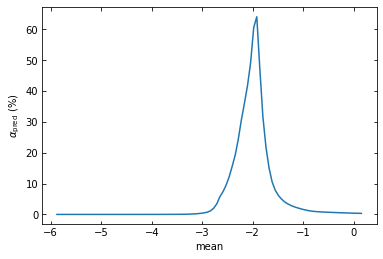

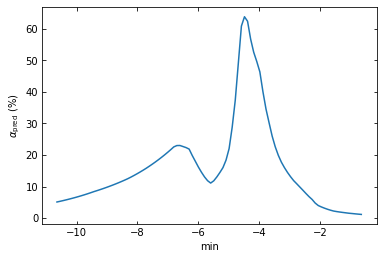

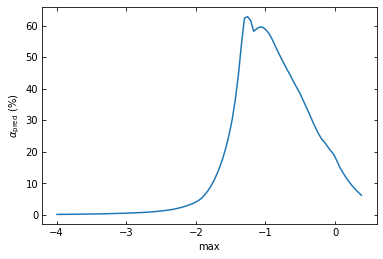

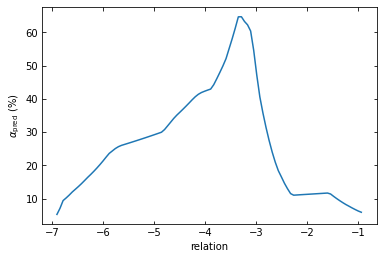

Hidden Layer $i$  Nodes $l_i$
0                 1           20
1                 2           40
2                 3           50
3                 4           40
4                 5           20
5                 6           10
6                 7            5

In [38]:
x = zorin_ageev_with_spectral_features[['mean', 'min', 'max', 'relation']]
y = np.log(zorin_ageev_with_spectral_features['alpha'])
x_measured, y_measured = field_data_with_spectral_features[['mean', 'min', 'max', 'relation']], y_measured

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.6, test_size=0.4)

regressor_features = MLPRegressor(solver='adam', activation='relu', n_iter_no_change=10,
                         hidden_layer_sizes=(20, 40, 50, 40, 20, 10, 5), batch_size=400, max_iter=1000)

fitted_regressor_features = utils.ml.fit_model('features', regressor_features, x_train, y_train, param_grid_neural)

print(f"Free parameters: {utils.ml.get_num_of_free_parameters(fitted_regressor_features)}")
utils.ml.eval_model('features', fitted_regressor_features, x_train, y_train, x_test, y_test, x_measured, y_measured)
utils.ml.plot_learning_history(fitted_regressor_features, 'features')
utils.ml.export_model(fitted_regressor_features, '../models/features.pickle')

features = ['mean', 'min', 'max', 'relation']
utils.ml.vary_features(fitted_regressor_features, features, x_test)
utils.ml.get_table_of_layer_sizes(fitted_regressor_features)


## $k$-nearest Neighbors Regressor on Spectral Features

Finished `fit_model` in 411.07927 s.


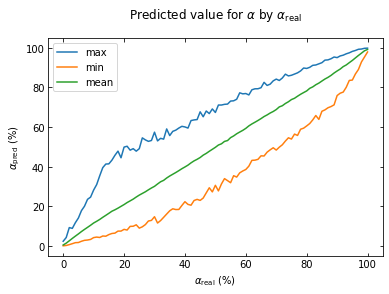

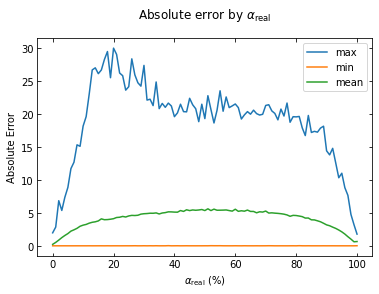

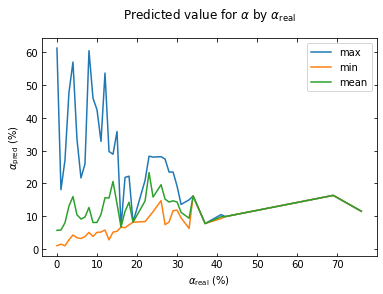

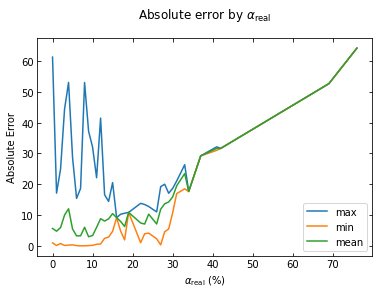

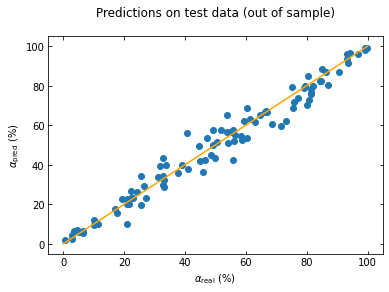

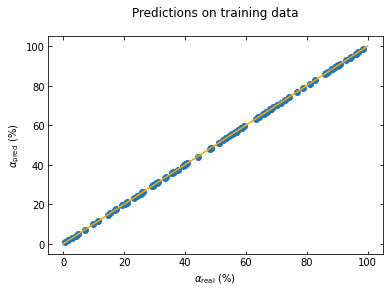

Maximal ice content: 61.30%
Minimal ice content: 0.93%


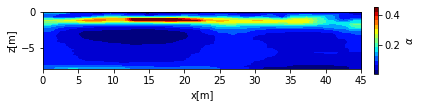

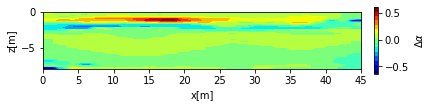

Finished `eval_model` in 64.68217 s.


score       RMSE
train       1.000000   0.000000
test        0.956863   5.456918
field data -0.266631  10.525853

In [39]:
x = zorin_ageev_with_spectral_features[['mean', 'min', 'max', 'relation']]
y = np.log(zorin_ageev_with_spectral_features['alpha'])

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, test_size=0.4)
regressor_k_neigh = KNeighborsRegressor()

fitted_regressor_k_neigh = utils.ml.fit_model('k_neigh', regressor_k_neigh, x_train, y_train, param_grid_k_neigh)
utils.ml.eval_model('k_neigh', fitted_regressor_k_neigh, x_train, y_train, x_test, y_test,
                  field_data_with_spectral_features[['mean', 'min', 'max', 'relation']], y_measured)
utils.ml.export_model(fitted_regressor_k_neigh, '../models/k_neigh.pickle')

## Example Feature Scaling

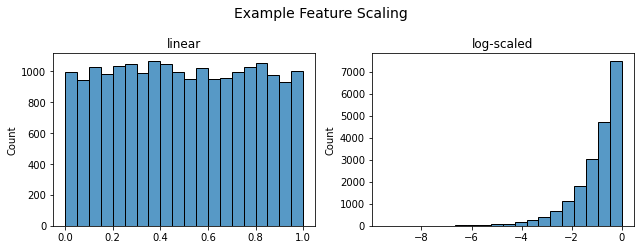

In [40]:
feature_scaling_hist_plot()